# Comparison of Mantaray Ray Tracing to Analytical Solutions

For some simple cases, such as a shallow step function bathymetry without currents, and for a shear current in deep water, the ray trajectory can be calculated analytically. This notebook validates the outputs from the Mantaray `single_ray()` function against these analytical solutions to demonstrate its accuracy

## Core Code and Functions

In [1]:
from mantaray.core import single_ray
from support import (
    c_and_cg_calc,
    c_deep,
    c_shallow,
)  # Functions to compute phase speed and group velocity
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


def snells_law_bathymetry(phi, old_c, new_c):
    """
    Snell's Law for ray incident on shear v current boundary (specifically passing from zero current region
    to non-zero v current region)
    Args:
        phi (float): Angle relative to x axis of ray incident on boundary
        old_c (float): Phase speed of ray incident on boundary
        new_c (float): Phase speed of transmitted ray
    Returns:
        new_phi (float): Angle relative to x axis of transmitted ray
    """
    return np.arcsin(np.sin(phi) * new_c / old_c)


def snells_law_shear_current(phi, old_c, v):
    """
    Snell's Law for ray incident on shear v current boundary (specifically passing from zero current region
    to non-zero v current region)
    Args:
        phi (float): Angle relative to x axis of ray incident on boundary
        old_c (float): Phase speed of ray incident on boundary
        v (float): v current velocity on transmission side of interface
    Returns:
        new_phi (float): Angle relative to x axis of transmitted ray
    """
    return np.arcsin(np.sin(phi) / (1 - v / old_c * np.sin(phi)) ** 2)


def analytical_ray_trace(
    xs, y0, phi0, k0, mode="shallow_bathymetry", depths=None, v_currents=None
):
    """
    Analytically trace ray at angle phi0 from x axis with wavenumber k0, through points xs.
    Assumes that medium changes are a function of x only (invariant in y, such that k_y is a constant).
    Args:
        xs (np.array): Array of x coordinates to trace through (each x corresponds to a change in the medium)
        y0 (float): Initial y value of ray (corresponding to xs[0])
        phi0 (float): Initial angle from x axis of ray in radians
        k0 (float): Initial wavenumber of the ray
        mode (str): Select which version of snell's law is used to compute refraction, and how to calculate phase
            speed and group velocity (deep or shallow water approximation).
            - Options:
                - 'shallow_bathymetry': Refraction in shallow water due to bathymetry, neglecting currents. Uses shallow
                    water approximation.
                - 'shear_currents': Refraction in deep water due to shear v current boundary (u currents assumed to be 0).
                    Uses deep water approximation.
        depths (np.array): Array of depths. Each value corresponds to a space between 2 subsequent xs coordinates,
            so depths should have length = len(xs)-1. If not provided, uniform depths of 10,000 m are used.
        v_currents (np.array): Array of v direction currents. Each value corresponds to a space between 2 subsequent
            xs coordinates, so v_currents should have length = len(xs)-1. If not provided, zero current field is used.
    Returns:
        ys (np.array): Array of ray y values corresponding to provided x values in xs
        phis (np.array): Array of ray angles. Each value corresponds to a space between subsequent xs coordinates, so
            len(phis) = len(xs)-1.
        ks (np.array): Array of ray wavenumber values. Each value corresponds to a space between subsequent xs
            coordinates, so len(ks) = len(xs)-1
    """
    # Initialize Arrays for ys, angles (phis), wavenumber (ks) and phase speeds (cs)
    phis = np.ones(shape=len(xs) - 1)
    phis[0] = phi0
    ks = np.ones(shape=len(xs) - 1)
    ks[0] = k0
    ky0 = k0 * np.sin(phi0)
    cs = np.ones(shape=len(xs) - 1)
    ys = np.ones(shape=len(xs))
    ys[0] = y0

    # If no currents provided, initialize array of 0s
    if v_currents is None:
        v_currents = np.zeros(shape=len(xs) - 1)

    # If no depth provided, assume deep water flat bathymetry
    if depths is None:
        depths = np.ones(shape=len(xs) - 1) * 10000

    # Set mode for computing refraction and wave speed
    snells_law_func_dict = {
        "shallow_bathymetry": snells_law_bathymetry,
        "shear_currents": snells_law_shear_current,
    }
    snells_law_func = snells_law_func_dict[mode]

    # Compute initial phase speed, group velocity using full dispersion relationship
    cs[0], cg = c_and_cg_calc(
        depths[0], ks[0]
    )  # group velocity not stored in array, but as single updated value

    # Iterate over each xs aside from last 2, compute y, phi, k, c, cg for next region
    for (
        i,
        x,
    ) in enumerate(xs[:-2]):
        # If shallow water bathymetry, compute transmitance phase speed (necessary to compute refraction with snell's law)
        if mode == "shallow_bathymetry":
            # Use shallow water approximation to calculate new phase speed, group velocity
            cs[i + 1] = c_shallow(depths[i + 1])
            cg = cs[i + 1]
        # Compute new phi
        snells_law_args_dict = {
            "shallow_bathymetry": {"phi": phis[i], "old_c": cs[i], "new_c": cs[i + 1]},
            "shear_currents": {"phi": phis[i], "old_c": cs[i], "v": v_currents[i + 1]},
        }
        snells_law_args = snells_law_args_dict[mode]
        phis[i + 1] = snells_law_func(**snells_law_args)

        # Compute new k
        ks[i + 1] = ky0 / np.sin(phis[i + 1])

        # If deep shear currents, calculate phase speed (needed new wavenumber from snell's law first)
        if mode == "shear_currents":
            # Use deep water approximation to calculate new phase speed, group velocity
            cs[i + 1] = c_deep(ks[i + 1])
            cg = cs[i + 1] * 0.5

        # Compute new y value for ray
        ys[i + 1] = ys[i] + (
            np.tan(phis[i]) + v_currents[i] / (cg * np.cos(phis[i]))
        ) * (xs[i + 1] - xs[i])

    # Compute y value at end of final region
    ys[-1] = ys[-2] + (np.tan(phis[-1]) + v_currents[-1] / (cg * np.cos(phis[-1]))) * (
        xs[-1] - xs[-2]
    )

    return phis, ys, ks

## Step Function Bathymetry

This section of the notebook analyzes the case for a long wave propagating through shallow water with step function bathymetry. It will refract towards the "coast" at the boundaries between bathymetry shelves. The angle of this refraction can be calculated using a form of Snell's Law for changes in bathymetry in the absence of currents according to the following formula:

$\frac{sin(\phi_1)}{sin(\phi_2)} = \frac{c_1}{c_2} = \frac{|\vec{K_2}|}{|\vec{K_1}|}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ and $c_2$ are the phase speeds of the wave before and after crossing the interface, and $\vec{K_1}$ and $\vec{K_2}$ are the wavenumbers of the incident and transmitted waves, respectively.

In the shallow water approximation, the phase speed $c = \sqrt{g d}$, where g is the acceleration of gravity and d is the depth of the wave.

### Import and Verify Current and Bathymetry Data
First, we import and plot the null current and shallow step function bathymetry to verify we are loading the correct data

Text(0.5, 1.0, 'V Current')

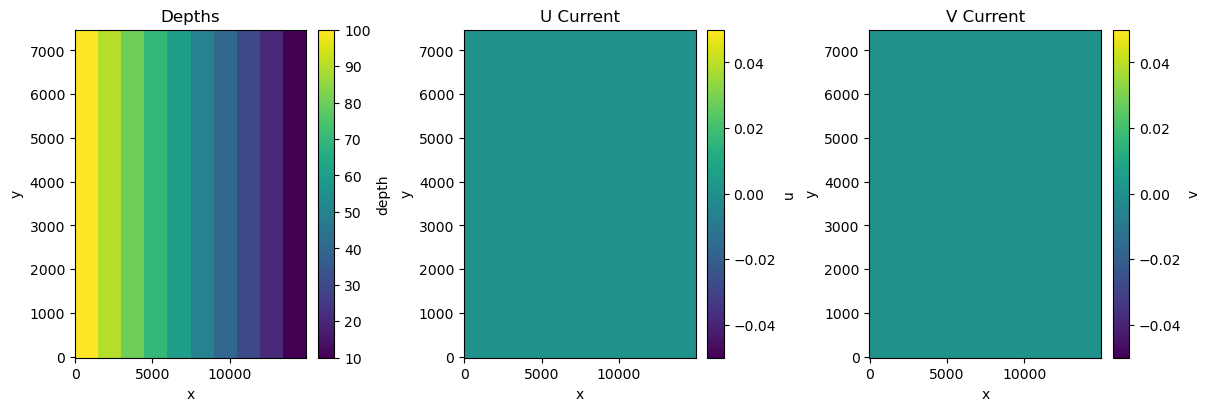

In [2]:
step_bathymetry_path = "forcing/step_bathymetry.nc"
null_current_path = "forcing/null_current.nc"
step_bathymetry = xr.open_dataset(step_bathymetry_path)
null_current = xr.open_dataset(null_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")
step_bathymetry.depth.plot(ax=ax_list[0])
null_current.u.plot(ax=ax_list[1])
null_current.v.plot(ax=ax_list[2])
ax_list[0].set_title("Depths")
ax_list[1].set_title("U Current")
ax_list[2].set_title("V Current")

### Define Environment and Ray Parameters
In this step, we save some parameters of our depth (the environmental factor causing the refraction) as variables so that the analytical ray trace can access them. We also define the parameters of our ray, such as wavelength, origin location, and launch angle.

In [3]:
# Save depth levels, locations of the shelves, as variables
depth_max = step_bathymetry.depth.max().values
NY, NX = step_bathymetry.depth.shape
dl = np.diff(step_bathymetry.x.values)[0]
depth_levels_raw, depth_indices_raw = np.unique(
    step_bathymetry.depth.sel(y=0).values, return_index=True
)
depth_indices = np.sort(depth_indices_raw)
depth_levels = step_bathymetry.depth.sel(y=0).values[depth_indices]
n_shelfs = len(depth_levels)
d_depths = np.diff(depth_levels_raw)[0]

# Define wave parameters
k = 2 * np.pi / 10000  # lambda = 10000m
phi0 = np.pi / 8
kx = k * np.cos(phi0)
ky = k * np.sin(phi0)

# Define ray initial positon
x0 = 50  # Offset from 0 by 1 step
y0 = 500

### Run Mantaray Ray Trace
We now run the Mantaray ray trace using our wave parameters and current and depth paths. We add variables to the output dataset for ray angle and wavenumber magnitude.

In [4]:
# Run single ray trace with step bathymetry and null current netcdf files from data subdirectory
ray_evolution_raw = single_ray(
    x0,
    y0,
    kx,
    ky,
    1000,
    0.5,
    bathymetry=step_bathymetry_path,
    current=null_current_path,
)
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(
    k=np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
    phi=np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx),
)

### Analytically Solve for Ray Path
We first build an array of x values corresponding to boundaries of different bathymetry shelves. For this case, we need 11 points to define our ray across the bathymetry steps. We then run the `analytical_ray_trace()` function to theoretically calulcate the ray trajectory. 

In [5]:
# Pick x values corresponding to the different boundaries
shelf_edge_xs = step_bathymetry.x.values[depth_indices]
xs_analytical = np.append(
    shelf_edge_xs, step_bathymetry.x.values[-1]
)  # Add final right side boundary to xs_analytical
mid_shelf_xs = shelf_edge_xs + np.diff(xs_analytical) / 2
# Offset first x value to match mantaray ray trace location
xs_analytical[0] = 50

phis_analytical, ys_analytical, ks_analytical = analytical_ray_trace(
    xs_analytical, y0, phi0, k, mode="shallow_bathymetry", depths=depth_levels
)

### Compute Ray Trace Error and Plot Rays
Finally, we compare the analytically calculated ray angles to those computed with Mantaray, displaying the output in a contour plot.

<>:16: SyntaxWarning: invalid escape sequence '\c'
<>:16: SyntaxWarning: invalid escape sequence '\c'
C:\Users\james\AppData\Local\Temp\ipykernel_35436\3983844315.py:16: SyntaxWarning: invalid escape sequence '\c'
  ax.text(x=shelf_edge_xs[i], y=ys_analytical[i]+1100, s='Δ φ:\n{a:1.4f}$^\circ$\n{b:1.3f}'.format(a=phi_diffs_degrees[i], b=phi_diffs_percent[i]) + '%')


Text(0, 0.5, 'Depth [m]')

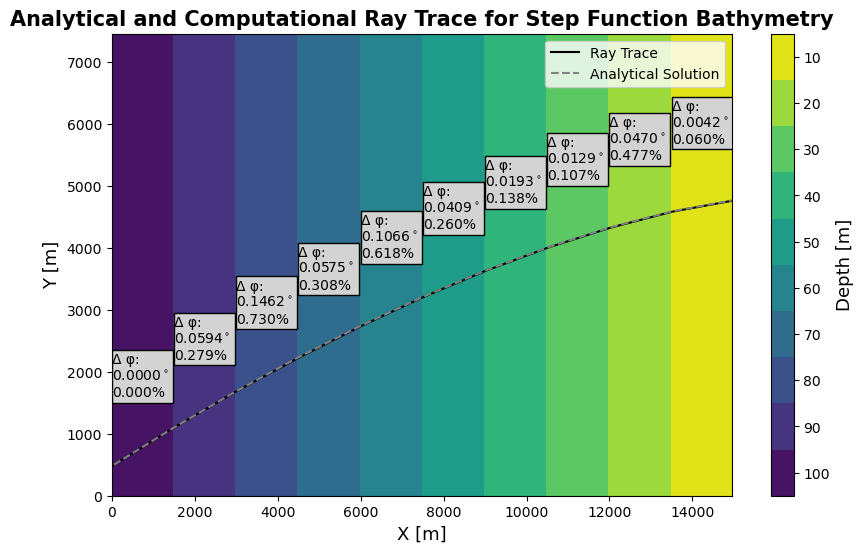

In [6]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(
    data=ray_evolution.phi.values[:-1], coords={"x": ray_evolution.x.values[:-1]}
)

# Find the difference and percent difference between the analytical and computational ray trace (taken in middle of step)
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_shelf_xs, method="nearest"))
phi_diffs_degrees = phi_diffs * 180 / np.pi
phi_diffs_percent = phi_diffs / phis_analytical * 100

# Plot the Ray Comparisons
fig, ax = plt.subplots(figsize=(10, 6))
contours = ax.contourf(
    step_bathymetry.x,
    step_bathymetry.y,
    step_bathymetry.depth,
    cmap="viridis_r",
    levels=np.append(depth_levels_raw, depth_levels_raw[-1] + d_depths) - d_depths / 2,
)
ax.autoscale(False)
ax.plot(
    ray_evolution.x,
    ray_evolution.y,
    marker="",
    linestyle="solid",
    color="black",
    label="Ray Trace",
)
ax.plot(
    xs_analytical,
    ys_analytical,
    marker="",
    linestyle="dashed",
    color="grey",
    label="Analytical Solution",
)
for i in range(len(phi_diffs)):
    ax.text(
        x=shelf_edge_xs[i],
        y=ys_analytical[i] + 1100,
        s="Δ φ:\n{a:1.4f}$^\circ$\n{b:1.3f}".format(
            a=phi_diffs_degrees[i], b=phi_diffs_percent[i]
        )
        + "%",
    )
    ax.add_patch(
        Rectangle(
            (shelf_edge_xs[i], ys_analytical[i] + 1000),
            width=np.diff(shelf_edge_xs)[0] - 30,
            height=850,
            facecolor="lightgray",
            edgecolor="black",
        )
    )
ax.legend()
ax.set_title(
    label="Analytical and Computational Ray Trace for Step Function Bathymetry",
    fontsize=15,
    fontweight="heavy",
)
ax.set_xlabel(xlabel="X [m]", fontsize=13)
ax.set_ylabel(ylabel="Y [m]", fontsize=13)
cax = fig.colorbar(contours)
cax.set_ticks(depth_levels_raw)
cax.ax.invert_yaxis()
cax.ax.set_ylabel("Depth [m]", fontsize=13)

## Shear Current

This section of the notebook analyzes the case of a short wave propagating through a shear current in deep water. The wave passes from an area of 0 currents to an area of non-zero v currents. The angle of refraction can be calculated using a form of Snell's Law for shear currents in deep water according to the following formula:

$sin(\phi _2) = \frac{sin(\phi _1)}{(1-\frac{V}{c_1} sin(\phi _1))^2}$

where the angles $\phi_1$ and $\phi_2$ are the incident and transmitted ray angles, $c_1$ is the phase speed of the wave before crossing the interface, and $V$ is the horizontally sheared current. 

In the deep water approximation, $c = \frac{g}{\omega _0} = \sqrt{\frac{g}{|\vec{K}|}}$, where $g$ is the acceleration of gravity, $\omega _0$ is the fundamental frequency of the wave, and $\vec{K}$ is the initial wavenumber.

### Import And Verify Current and Bathymetry Data
First, we import and plot our shear current and deep water bathymetry to verify we are loading the correct data

Text(0.5, 1.0, 'V Current')

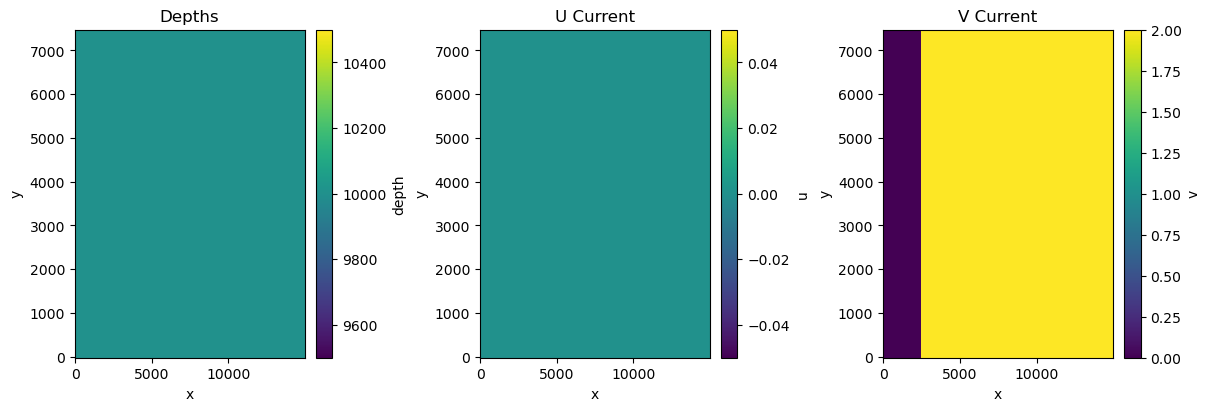

In [7]:
deep_flat_bathymetry_path = "forcing/deep_water_flat_bathymetry.nc"
shear_current_path = "forcing/shear_current_2v.nc"
deep_flat_bathymetry = xr.open_dataset(deep_flat_bathymetry_path)
shear_current = xr.open_dataset(shear_current_path)

# Plot Data to Verify
fig, ax_list = plt.subplots(1, 3, figsize=(12, 4), layout="constrained")
deep_flat_bathymetry.depth.plot(ax=ax_list[0])
shear_current.u.plot(ax=ax_list[1])
shear_current.v.plot(ax=ax_list[2])
ax_list[0].set_title("Depths")
ax_list[1].set_title("U Current")
ax_list[2].set_title("V Current")

### Define Environment and Ray Parameters
In this step, we save some parameters of our v currents (the environmental factor causing the refraction) as variables so that the analytical ray trace can access them. We also define the parameters of our ray, such as wavelength, origin location, and launch angle.

In [8]:
# Save current values, locations of changes in medium, as variables
v_currents_raw, v_current_indices_raw = np.unique(
    shear_current.v.values, return_index=True
)
v_current_indices = np.sort(v_current_indices_raw)
v_currents = shear_current.v.sel(y=0).values[v_current_indices]
n_zones = len(v_currents)
d_v_currents = np.diff(v_currents_raw)[0]

# Define wave parameters
period = 10  # s
lambda0 = 9.81 * period**2 / (2 * np.pi)
k = 2 * np.pi / lambda0
phi0 = 50 * np.pi / 180  # phi0 = 50 degrees from x axis
kx = k * np.cos(phi0)
ky = k * np.sin(phi0)

# Define ray initial positon
x0 = 50  # Offset from 0 by 1 step
y0 = 500

### Run Mantaray Ray Trace
We now run the Mantaray ray trace using our wave parameters and current and depth paths. We add variables to the output dataset for ray angle and wavenumber magnitude.

In [9]:
# Run single ray trace with deep water bathymetry and shear current files from data subdirectory
ray_evolution_raw = single_ray(
    x0,
    y0,
    kx,
    ky,
    40000,
    1,
    bathymetry=deep_flat_bathymetry_path,
    current=shear_current_path,
)
# Process ray trace dataset to add wavenumber magnitude and angle information
ray_evolution = ray_evolution_raw.assign(
    k=np.sqrt(ray_evolution_raw.kx**2 + ray_evolution_raw.ky**2),
    phi=np.arctan2(ray_evolution_raw.ky, ray_evolution_raw.kx),
)

### Analytically Solve for Ray Path
We first build an array of x values corresponding to boundaries of different zones. For this case, we need 3 points to define our ray across the shear current. We then run the `analytical_ray_trace()` function to theoretically calulcate the ray trajectory. 

In [10]:
# Pick x values corresponding to the different boundaries
zone_edge_xs = shear_current.x.values[v_current_indices]
xs_analytical = np.append(
    zone_edge_xs, shear_current.x.values[-1]
)  # Add final right side boundary to xs_analytical
mid_zone_xs = zone_edge_xs + np.diff(xs_analytical) / 2
# Offset first x value to match mantaray ray trace location
xs_analytical[0] = 50

phis_analytical, ys_analytical, ks_analytical = analytical_ray_trace(
    xs_analytical, y0, phi0, k, mode="shear_currents", v_currents=v_currents
)

c:\Users\james\Projects\SURF_2024\ray_tracing\notebooks\theoretical_comparison\support.py:34: RuntimeWarning: overflow encountered in sinh
  n = 0.5 * (1 + 2*k*depth / np.sinh(2*k*depth))


### Compute Ray Trace Error and Plot Rays
Finally, we compare the analytically calculated ray angles to those computed with Mantaray, displaying the output in a contour plot.

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
C:\Users\james\AppData\Local\Temp\ipykernel_35436\3144969528.py:20: SyntaxWarning: invalid escape sequence '\c'
  ax.text(x=zone_edge_xs[i], y=ys_analytical[i]+3600, s='Δ φ:\n{a:1.4f}$^\circ$\n{b:1.3f}'.format(a=phi_diffs_degrees[i], b=phi_diffs_percent[i]) + '%')
C:\Users\james\AppData\Local\Temp\ipykernel_35436\3144969528.py:23: SyntaxWarning: invalid escape sequence '\c'
  ax.text(x=zone_edge_xs[i]+200, y=ys_analytical[i]-1000, s='Δ φ:\n{a:1.4f}$^\circ$\n{b:1.3f}'.format(a=phi_diffs_degrees[i], b=phi_diffs_percent[i]) + '%')


Text(0, 0.5, 'V Currents [m/s]')

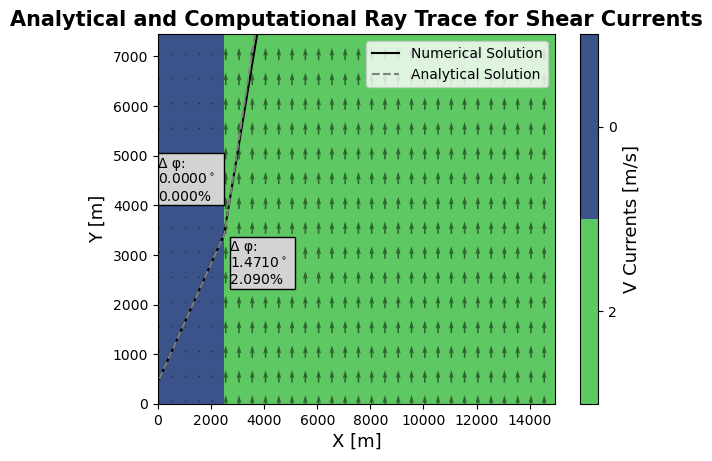

In [11]:
# Organize computed ray angles with "x" as a coordinate
ray_angles = xr.DataArray(
    data=ray_evolution.phi.values[:-1], coords={"x": ray_evolution.x.values[:-1]}
)

# Find the difference and percent difference between the analytical and computational ray trace (taken in middle of zone)
phi_diffs = np.abs(phis_analytical - ray_angles.sel(x=mid_zone_xs, method="nearest"))
phi_diffs_degrees = phi_diffs * 180 / np.pi
phi_diffs_percent = phi_diffs / phis_analytical * 100

# Plot the Ray Comparisons
fig, ax = plt.subplots()
contours = ax.contourf(
    shear_current.x,
    shear_current.y,
    shear_current.v,
    cmap="viridis",
    levels=np.append(v_currents_raw, v_currents_raw[-1] + d_v_currents)
    - d_v_currents / 2,
)
quiver_shear_currents = shear_current.sel(x=slice(10, None, 10), y=slice(10, None, 10))
ax.quiver(
    quiver_shear_currents.x,
    quiver_shear_currents.y,
    quiver_shear_currents.u,
    quiver_shear_currents.v,
    color="black",
    pivot="middle",
    width=0.004,
    alpha=0.5,
)
ax.autoscale(False)
ax.plot(
    ray_evolution.x,
    ray_evolution.y,
    marker="",
    linestyle="solid",
    color="black",
    label="Numerical Solution",
)
ax.plot(
    xs_analytical,
    ys_analytical,
    marker="",
    linestyle="dashed",
    color="grey",
    label="Analytical Solution",
)
for i in range(len(phi_diffs)):
    if i == 0:
        ax.text(
            x=zone_edge_xs[i],
            y=ys_analytical[i] + 3600,
            s="Δ φ:\n{a:1.4f}$^\circ$\n{b:1.3f}".format(
                a=phi_diffs_degrees[i], b=phi_diffs_percent[i]
            )
            + "%",
        )
        ax.add_patch(
            Rectangle(
                (zone_edge_xs[i], ys_analytical[i] + 3500),
                width=np.diff(zone_edge_xs)[0] - 30,
                height=1050,
                facecolor="lightgray",
                edgecolor="black",
            )
        )
        continue
    ax.text(
        x=zone_edge_xs[i] + 200,
        y=ys_analytical[i] - 1000,
        s="Δ φ:\n{a:1.4f}$^\circ$\n{b:1.3f}".format(
            a=phi_diffs_degrees[i], b=phi_diffs_percent[i]
        )
        + "%",
    )
    ax.add_patch(
        Rectangle(
            (zone_edge_xs[i] + 200, ys_analytical[i] - 1100),
            width=np.diff(zone_edge_xs)[0] - 30,
            height=1050,
            facecolor="lightgray",
            edgecolor="black",
        )
    )
ax.legend()
ax.set_title(
    label="Analytical and Computational Ray Trace for Shear Currents",
    fontsize=15,
    fontweight="heavy",
)
ax.set_xlabel(xlabel="X [m]", fontsize=13)
ax.set_ylabel(ylabel="Y [m]", fontsize=13)
cax = fig.colorbar(contours)
cax.set_ticks(v_currents_raw)
cax.ax.invert_yaxis()
cax.ax.set_ylabel("V Currents [m/s]", fontsize=13)